In [4]:
import numpy as np
import matplotlib.pyplot as plt

### **Exercise 1.**

Consider the initial value problem (IVP)  
$$
u' = \frac{u^2 + u}{t}, \quad 1 \le t \le 5, \quad u(1) = -2,
$$  
whose exact solution is  
$$
u(t) = \frac{2t}{1 - 2t}.
$$  

**Part A: Implementation**

Write a program (using a language like Python, MATLAB, or C++) to solve this IVP using the following **linear multistep methods (LMMs):**

1. **Adams-Bashforth 2-step (AB2)** – explicit LMM of order 2  
2. **Adams-Bashforth 4-step (AB4)** – explicit LMM of order 4  
3. **Adams-Moulton 2-step (AM2)** – implicit LMM of order 2  
4. **Backward Differentiation Formula 2-step (BDF2)** – implicit LMM of order 2  

For each method, initialize the required starting values:  

1. **Exact Initialization:** Assume the exact solution is known to generate the first few steps.  
2. **One-Step Initialization:** Use a one-step method consistent with the method’s order (e.g., Forward Euler for AB2, RK2 for AB4) to generate the starting values.



In [10]:
def f(t, u):
    return (u**2 + u) / t

def df_du(t, u):
    return (2.0 * u + 1.0) / t

def exact_solution(t):
    return (2.0 * t) / (1.0 - 2.0 * t)

def forward_euler_step(t, u, h):
    return u + h * f(t, u)

def rk2_step(t, u, h):
    k1 = f(t, u)
    k2 = f(t + 0.5 * h, u + 0.5 * h * k1)
    return u + h * k2

def rk4_step(t, u, h):
    k1 = f(t, u)
    k2 = f(t + 0.5*h, u + 0.5*h*k1)
    k3 = f(t + 0.5*h, u + 0.5*h*k2)
    k4 = f(t + h,     u + h*k3)
    return u + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def solve_lmm(method, h, init="exact"):
    t0, tf = 1.0, 5.0
    steps_float = (tf - t0) / h
    steps = int(round(steps_float))
    if abs(steps_float - steps) > 1e-12:
        raise ValueError("h must divide the time interval exactly")

    t = t0 + h * np.arange(steps + 1)
    u = np.zeros(steps + 1)
    fvals = np.zeros(steps + 1)

    u[0] = -2.0
    fvals[0] = f(t[0], u[0])

    need = {"AB2": 1, "AB4": 3, "AM2": 1, "BDF2": 1}[method]

    if init == "exact":
        for k in range(1, need + 1):
            u[k] = exact_solution(t[k])
            fvals[k] = f(t[k], u[k])
    elif init == "one-step":
        for idx in range(1, need + 1):
            t_prev, u_prev = t[idx - 1], u[idx - 1]
            if method == "AB2":
                u[idx] = forward_euler_step(t_prev, u_prev, h)
            elif method == "AB4":
                u[idx] = rk4_step(t_prev, u_prev, h)   # orden 4
            else:  # AM2 y BDF2
                u[idx] = rk2_step(t_prev, u_prev, h)
            fvals[idx] = f(t[idx], u[idx])
    else:
        raise ValueError("Unknown initialization strategy")

    if method == "AB2":
        for n in range(1, steps):
            u[n + 1] = u[n] + 0.5*h*(3.0*fvals[n] - fvals[n - 1])
            fvals[n + 1] = f(t[n + 1], u[n + 1])

    elif method == "AB4":
        for n in range(3, steps):
            term = 55.0*fvals[n] - 59.0*fvals[n - 1] + 37.0*fvals[n - 2] - 9.0*fvals[n - 3]
            u[n + 1] = u[n] + (h/24.0)*term
            fvals[n + 1] = f(t[n + 1], u[n + 1])

    elif method == "AM2":
        for n in range(1, steps):
            tn1 = t[n + 1]
            fn, fnm1 = fvals[n], fvals[n - 1]
            A = (5.0*h) / (12.0*tn1)                     # a
            B = u[n] + (h/12.0)*(8.0*fn - fnm1)          # c
            a, b, c = A, (A - 1.0), B
            D = b*b - 4.0*a*c
            if D < 0.0: D = 0.0
            u[n + 1] = (-b - np.sqrt(D)) / (2.0*a)       # raíz negativa
            fvals[n + 1] = f(tn1, u[n + 1])

    elif method == "BDF2":
        for n in range(1, steps):
            tn1 = t[n + 1]
            A = (2.0*h) / (3.0*tn1)                      # a
            B = (4.0*u[n] - u[n - 1]) / 3.0              # c
            a, b, c = A, (A - 1.0), B
            D = b*b - 4.0*a*c
            if D < 0.0: D = 0.0
            u[n + 1] = (-b - np.sqrt(D)) / (2.0*a)       # raíz negativa
            fvals[n + 1] = f(tn1, u[n + 1])

    else:
        raise ValueError("Unsupported method")

    return t, u

h = 0.2
methods = ["AB2", "AB4", "AM2", "BDF2"]
for init_strategy in ["exact", "one-step"]:
    print(f"Initialization: {init_strategy}")
    for method in methods:
        times, values = solve_lmm(method, h, init_strategy)
        err = abs(values[-1] - exact_solution(times[-1]))
        print(f"  {method}: u(5) = {values[-1]:.8f}, error = {err:.2e}")
    print()


Initialization: exact
  AB2: u(5) = -1.12504519, error = 1.39e-02
  AB4: u(5) = -1.11744899, error = 6.34e-03
  AM2: u(5) = -1.11211422, error = 1.00e-03
  BDF2: u(5) = -1.10125387, error = 9.86e-03

Initialization: one-step
  AB2: u(5) = -1.11603045, error = 4.92e-03
  AB4: u(5) = -1.11744625, error = 6.34e-03
  AM2: u(5) = -1.11432395, error = 3.21e-03
  BDF2: u(5) = -1.10602701, error = 5.08e-03



**Part B: Convergence Analysis**

Analyze the **convergence** of each method by comparing the numerical solution against the exact solution $u(t)$ at the final time $t = 5$. Use a sequence of step sizes:  
$$
\Delta t_m = \frac{0.2}{2^m}, \quad m = 0, 1, \dots, 6.
$$

The exact value at $t = 5$ is  
$$
u(5) = \frac{2 \cdot 5}{1 - 2 \cdot 5} = -\frac{10}{9}.
$$

**Required Deliverables:**

1. **Tabular Results:** For each method, present a table showing $\Delta t_m$, the absolute error  
   $$
   \mathcal{E}(\Delta t_m) = \left| U^N(\Delta t_m) - u(5) \right|,
   $$  
   and the **estimated order of convergence** $p$ between consecutive step sizes.  
2. **Log-Log Plot:** Generate a single log-log plot showing the absolute error $\mathcal{E}$ versus the step size $\Delta t$ for all four methods.

Initialization: exact
  AB2 results:
    dt = 0.200000 | error = 1.393e-02 | p = -
    dt = 0.100000 | error = 3.611e-03 | p = 1.95
    dt = 0.050000 | error = 9.169e-04 | p = 1.98
    dt = 0.025000 | error = 2.308e-04 | p = 1.99
    dt = 0.012500 | error = 5.790e-05 | p = 2.00
    dt = 0.006250 | error = 1.450e-05 | p = 2.00
    dt = 0.003125 | error = 3.627e-06 | p = 2.00

  AB4 results:
    dt = 0.200000 | error = 6.338e-03 | p = -
    dt = 0.100000 | error = 6.396e-04 | p = 3.31
    dt = 0.050000 | error = 5.278e-05 | p = 3.60
    dt = 0.025000 | error = 3.841e-06 | p = 3.78
    dt = 0.012500 | error = 2.601e-07 | p = 3.88
    dt = 0.006250 | error = 1.694e-08 | p = 3.94
    dt = 0.003125 | error = 1.081e-09 | p = 3.97

  AM2 results:
    dt = 0.200000 | error = 1.003e-03 | p = -
    dt = 0.100000 | error = 1.517e-04 | p = 2.73
    dt = 0.050000 | error = 2.112e-05 | p = 2.84
    dt = 0.025000 | error = 2.797e-06 | p = 2.92
    dt = 0.012500 | error = 3.604e-07 | p = 2.96
    dt = 

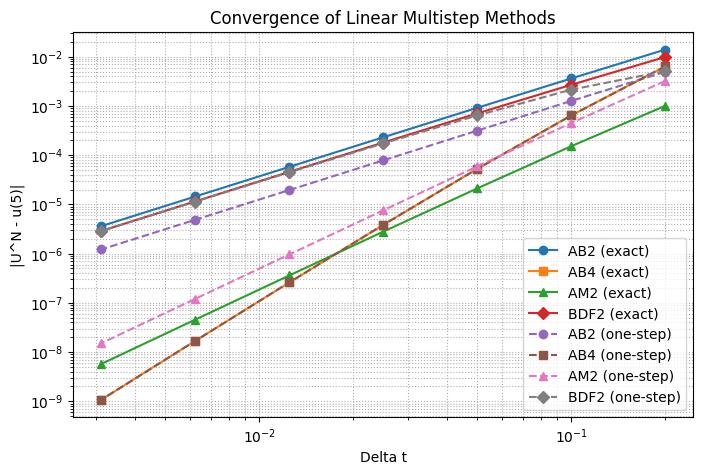

In [11]:
step_sizes = [0.2 / (2 ** m) for m in range(7)]
methods = ['AB2', 'AB4', 'AM2', 'BDF2']
init_strategies = ['exact', 'one-step']
exact_target = exact_solution(5.0)

results = {init: {method: {'dt': [], 'error': []} for method in methods} for init in init_strategies}
for dt in step_sizes:
    for init in init_strategies:
        for method in methods:
            _, values = solve_lmm(method, dt, init)
            err = abs(values[-1] - exact_target)
            results[init][method]['dt'].append(dt)
            results[init][method]['error'].append(err)

def estimate_orders(errors, steps):
    orders = [np.nan]
    for k in range(len(errors) - 1):
        e_curr, e_next = errors[k], errors[k + 1]
        if e_curr > 0.0 and e_next > 0.0:
            ratio_e = e_curr / e_next
            ratio_h = steps[k] / steps[k + 1]
            orders.append(np.log(ratio_e) / np.log(ratio_h))
        else:
            orders.append(np.nan)
    return orders

for init in init_strategies:
    print(f'Initialization: {init}')
    for method in methods:
        dts = results[init][method]['dt']
        errors = results[init][method]['error']
        orders = estimate_orders(errors, dts)
        print(f'  {method} results:')
        for dt_value, err_value, order_value in zip(dts, errors, orders):
            if np.isfinite(order_value):
                order_str = f'{order_value:.2f}'
            else:
                order_str = '-'
            print(f'    dt = {dt_value:.6f} | error = {err_value:.3e} | p = {order_str}')
        print()
    print()

markers = {'AB2': 'o', 'AB4': 's', 'AM2': '^', 'BDF2': 'D'}
linestyles = {'exact': '-', 'one-step': '--'}
plt.figure(figsize=(8, 5))
for init in init_strategies:
    for method in methods:
        dts = results[init][method]['dt']
        errors = results[init][method]['error']
        label = f'{method} ({init})'
        plt.loglog(dts, errors, marker=markers[method], linestyle=linestyles[init], label=label)
plt.xlabel('Delta t')
plt.ylabel('|U^N - u(5)|')
plt.title('Convergence of Linear Multistep Methods')
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.show()
